# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [39]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [40]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [ ]:
# regress 'pocketEval' on 'trumpft'
X_pocket = ANES['pocketEval']
X_pocket = sm.add_constant(X_pocket)
y = ANES['trumpft']
model_pocket = sm.OLS(y, X_pocket).fit()

# regresss 'econEval' on 'trumpft'
X_econ = ANES['econEval']
X_econ = sm.add_constant(X_econ)
model_econ = sm.OLS(y, X_econ).fit()

# compare the models
print(model_pocket.summary())
print(model_econ.summary())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     304.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           6.59e-67
Time:                        13:46:07   Log-Likelihood:                -40764.
No. Observations:                7998   AIC:                         8.153e+04
Df Residuals:                    7996   BIC:                         8.155e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.1407      0.443     90.694      0.0

## More Complex OLS Regressions (+ Covariates)

In [42]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# regress 'trumpft' on 'pocketEval' variable + covariates
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_pocket_cov = sm.add_constant(X_pocket_cov)
model_pocket_cov = sm.OLS(y, X_pocket_cov).fit()

# regress 'trumpft' on 'econEval' variable + covariates
X_econ_cov = ANES[['econEval'] + covariates]
X_econ_cov = sm.add_constant(X_econ_cov)
model_econ_cov = sm.OLS(y, X_econ_cov).fit()

# compare the models with the covariates
# NOTE: the coefficient for pocketEval is no longer significant at p<0.05
print(model_pocket_cov.summary())
print(model_econ_cov.summary())


                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:46:07   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  100.6644 

## LASSO Regression

In [43]:
# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train, y_test = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train, y_test = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# fit LASSO models
lasso_pocket = Lasso(alpha=0.5, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train)

lasso_econ = Lasso(alpha=0.5, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train)

# compare the selected features for the two models
print('Selected features for pocketEval model:')
print(X_pocket_cov.columns[lasso_pocket.coef_ != 0])
print('Number of selected features:', sum(lasso_pocket.coef_ != 0))

print('Selected features for econEval model:')
print(X_econ_cov.columns[lasso_econ.coef_ != 0])
print('Number of selected features:', sum(lasso_econ.coef_ != 0))

Selected features for pocketEval model:
Index(['sp_serv', 'sp_serv_biden', 'sp_serv_trump', 'jobs_living',
       'jobs_living_trump', 'envir_business', 'envir_business_trump',
       'abortion', 'abortion_biden', 'covid_approval', 'covid_response_speed',
       'mail_in_attitude', 'police_treat', 'repro', 'mail_in', 'stateFIPS',
       'age', 'marital', 'income', 'ideology', 'trans', 'immigration',
       'gun_diff', 'offensive_language'],
      dtype='object')
Number of selected features: 24
Selected features for econEval model:
Index(['sp_serv', 'sp_serv_biden', 'sp_serv_trump', 'jobs_living',
       'jobs_living_trump', 'envir_business', 'envir_business_trump',
       'abortion', 'abortion_biden', 'covid_approval', 'covid_response_speed',
       'mail_in_attitude', 'police_treat', 'repro', 'mail_in', 'stateFIPS',
       'age', 'marital', 'income', 'ideology', 'trans', 'immigration',
       'gun_diff', 'offensive_language'],
      dtype='object')
Number of selected features: 24


## Neural Network (?)

In [44]:
# train a neural network on pocketEval model
class ANESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, output_dim, n_epochs=25):
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train, y_train)
    anes_test = ANESDataset(X_test, y_test)

    train_loader = DataLoader(anes_train, batch_size=32, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=32, shuffle=False)


    n_epochs = 25
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader

anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train, X_pocket_cov_test, y_test, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 1273.9206425476075, Test Loss: 479.48895935058596
Epoch 2, Train Loss: 350.27815841674806, Test Loss: 282.79182067871096
Epoch 3, Train Loss: 277.16860149383547, Test Loss: 253.08736221313475
Epoch 4, Train Loss: 253.1302979660034, Test Loss: 242.48649658203124
Epoch 5, Train Loss: 239.19052242279054, Test Loss: 230.1553663635254
Epoch 6, Train Loss: 228.64015522003174, Test Loss: 217.9446856689453
Epoch 7, Train Loss: 222.5137395095825, Test Loss: 213.46723876953126
Epoch 8, Train Loss: 218.74718900680543, Test Loss: 209.5499267578125
Epoch 9, Train Loss: 215.6837953567505, Test Loss: 210.84009185791015
Epoch 10, Train Loss: 213.2277346801758, Test Loss: 208.3558737182617
Epoch 11, Train Loss: 211.47082950592042, Test Loss: 207.62141342163085
Epoch 12, Train Loss: 208.366000289917, Test Loss: 203.25782012939453
Epoch 13, Train Loss: 208.94729446411134, Test Loss: 206.0297589111328
Epoch 14, Train Loss: 206.5553705596924, Test Loss: 202.8971438598633
Epoch 15, Trai

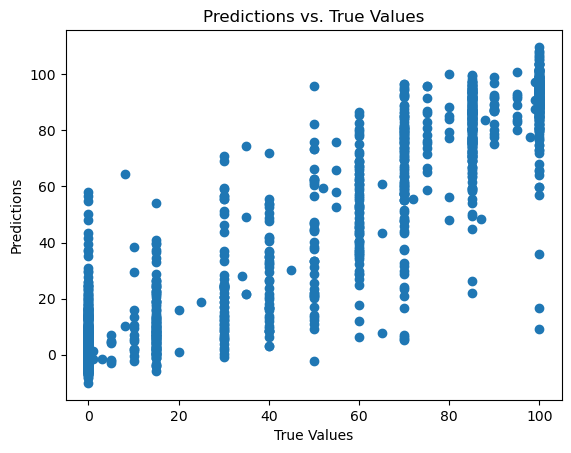

In [45]:
anes_net_pocket.eval()
correct_predictions = 0
total_predictions = 0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()


In [46]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net = ANESNet(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(anes_net.parameters(), lr=0.001)



## Random Forest

In [ ]:
# run a Random Forest on pocketEval and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
rf_pocket.fit(X_pocket_cov, y)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

In [ ]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
rf_econ.fit(X_econ_cov, y)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

,Feature,Importance
40,immigration,0.483851
20,covid_approval,0.346911
36,ideology,0.023738
12,envir_business_trump,0.012828
10,envir_business,0.007703
29,age,0.007447
6,sp_serv_trump,0.007284
23,police_treat,0.006106
27,stateFIPS,0.005959
35,income,0.005694
